1. Introduction
## What is autoencoding?

Autoencoding is much kile what it sounds in the sense that the input and 'output'
are essentially the same. It's an algorithm for data compression where the functions 
for compression and decompression are learned from data. It's considered more of a 
semi-supervised learning method as opposed to a truly unsupervised one since it's
not entirely 'targetless'. Instead it learns the targets from the data itself.

## Autoencoders 
Generally autoencoders have three parts: an encoder, a decoder, and a 'loss' function
that maps one to the other. For the simplest autoencoders we can think of the 'loss' 
as describing the amount of information lost in the process of reconstruction.

2. Data preparation

In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

K.clear_session()

np.random.seed(237)
print('keras:', keras.__version__)


keras: 2.2.4


In [7]:
train = pd.read_csv('../data/digit-recognizer/train.csv')
test = pd.read_csv('../data/digit-recognizer/test.csv')

print('Train len:', len(train))
print('Test len:', len(test))

Train len: 42000
Test len: 28000


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
train.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reshape & normalize

In [30]:
x_train = train.drop(['label'], axis=1)
x_train = x_train.astype('float32') / 255.
x_train = x_train.values.reshape(-1, 28, 28, 1)
print('x_train.shape:', x_train.shape)


x_test = test.astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1)
print('x_test.shape:', x_test.shape)

x_train.shape: (42000, 28, 28, 1)
x_test.shape: (28000, 28, 28, 1)


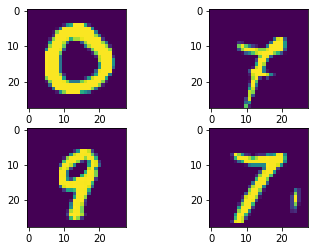

In [31]:
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train[4][:,:,0])

plt.subplot(222)
plt.imshow(x_train[690][:,:,0])

plt.subplot(223)
plt.imshow(x_train[2375][:,:,0])

plt.subplot(224)
plt.imshow(x_train[4201][:,:,0])
plt.show()

## 3. Parameter

In [32]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

## 4. Model Construction
### 3.1 Encoder network
A VAE has three parts:
i) An encoder that learns the parameters (mean and variance) of the 
underlying latent distribution.
ii) An means of sampling from that distribution.
iii) A decoder that turn the sample from #2 back to an image.

Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense

In [ ]:
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
